In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import pandas as pd
import numpy as np
import plotnine as p9
import matplotlib.pyplot as plt
import ast

In [2]:
# date_time = "2023-04-08_17:38"
date_time = "2023-04-08_21:05"
date_time = "2023-04-09_15:31"
date_time = "2023-04-09_16:40"
date_time = "2023-06-01_14:32"
# date_time = "2023-06-21_20:44" # necromass_bacteria

root_dir = "/projects/genomic-ml/da2343/ml_project_1/model_complexity/lasso_coef"
model_complexity_df = pd.read_csv(f"{root_dir}/lasso_coef_{date_time}.csv")

In [3]:
model_complexity_df

,subtrain_score,validation_score,reg_param,algorithm,data_set_name,fold_id,index_of_pred_col,coefs
0,0.024444,5.087223,1.000000e-07,LASSO,amgut2,0,32,[-0.040874004361986835 0.06962700300367054 -0....
1,0.024443,5.081424,1.000000e-06,LASSO,amgut2,0,32,[-0.04086470936007607 0.069441287940298 -0.047...
2,0.024430,5.023808,1.000000e-05,LASSO,amgut2,0,32,[-0.04079240353764783 0.06774590285867363 -0.0...
3,0.024502,4.483499,1.000000e-04,LASSO,amgut2,0,32,[-0.04074022853629966 0.055057124646745594 -0....
4,0.034299,2.102329,1.000000e-03,LASSO,amgut2,0,32,[-0.0594595114600811 0.0010481837334579901 -0....
...,...,...,...,...,...,...,...,...
23593,0.921239,1.051498,7.733344e-01,LASSO,amgut2,2,108,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...
23594,0.925558,1.053784,8.693280e-01,LASSO,amgut2,2,108,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...
23595,0.925558,1.053784,9.772372e-01,LASSO,amgut2,2,108,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...
23596,0.925558,1.053784,1.000000e+00,LASSO,amgut2,2,108,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0...


Best reg_param for amgut2 FoldID:0 is -1.1279591836734693
Best no of edges for amgut2 FoldID:0 is 1559


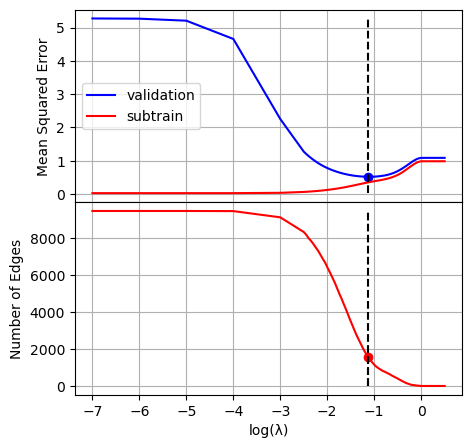

Best reg_param for amgut2 FoldID:1 is -1.1279591836734693
Best no of edges for amgut2 FoldID:1 is 1585


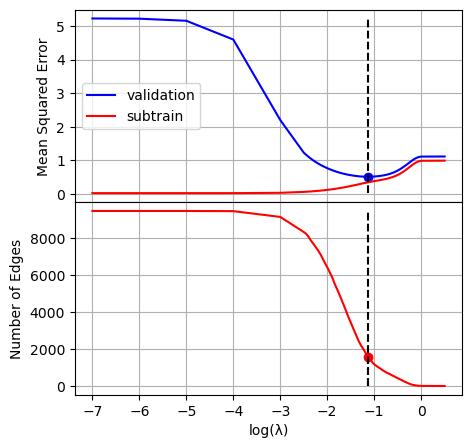

Best reg_param for amgut2 FoldID:2 is -1.1279591836734693
Best no of edges for amgut2 FoldID:2 is 1493


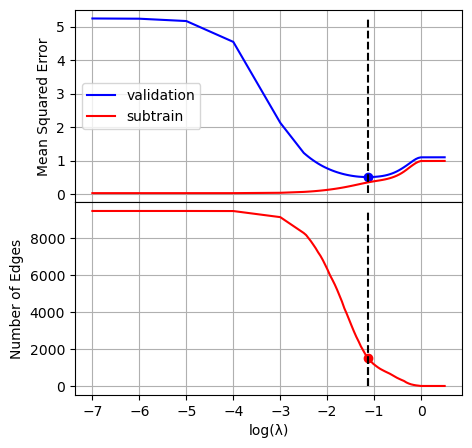

In [4]:
algorithm_list = model_complexity_df["algorithm"].unique()

for algorithm in algorithm_list:
    filtered_algorithm_df = model_complexity_df[model_complexity_df["algorithm"] == algorithm]
    dataset_list = filtered_algorithm_df["data_set_name"].unique().tolist()
    for dataset in dataset_list:
        # Get new dataframe with only the dataset
        sub_dataset_df = filtered_algorithm_df[filtered_algorithm_df["data_set_name"] == dataset]
        fold_id_list = sub_dataset_df["fold_id"].unique().tolist()
        
        for fold_id  in fold_id_list :
            test_error_df_list = []
            filtered_fold_id_df = sub_dataset_df[sub_dataset_df["fold_id"] == fold_id]
            reg_param_list = filtered_fold_id_df["reg_param"].unique().tolist()
            for reg_param in reg_param_list:
                filtered_reg_param = filtered_fold_id_df[filtered_fold_id_df["reg_param"] == reg_param]
                subtrain_score = filtered_reg_param['subtrain_score'].mean()
                validation_score = filtered_reg_param['validation_score'].mean()
                edges = 0
                index_of_pred_col_list = sorted(filtered_reg_param["index_of_pred_col"].unique().tolist())
                
                coef_matrix_list = []
                for index_of_pred_col in index_of_pred_col_list:
                    filtered_index_of_pred = filtered_reg_param[filtered_reg_param['index_of_pred_col'] == index_of_pred_col]
                    coefs = filtered_index_of_pred['coefs'].values.tolist()
                    coefs_str =  coefs[0]
                    # Replace "None" with "nan"
                    coefs_str = coefs_str.replace("None", "nan")
                    coefs_str = coefs_str.replace("\n", "")
                    coefs_str = coefs_str.replace("[", "")
                    coefs_str = coefs_str.replace("]", "")
                    
                    # Convert string to numpy array
                    coefs_arr = np.fromstring(coefs_str, sep=" ")
                    coef_matrix_list.append(coefs_arr)
                
                # Convert the list of numpy arrays into a matrix
                coefs_mat = np.array(coef_matrix_list)
                # get the indices of the upper and lower triangle elements
                upper_tri = np.triu_indices(coefs_mat.shape[0], k=1)
                lower_tri = np.tril_indices(coefs_mat.shape[0], k=-1)
                 # calculate the average of the upper and lower triangle elements
                avg_matrix = (coefs_mat + coefs_mat.T) / 2
                coefs_mat[lower_tri] = avg_matrix[lower_tri]
                coefs_mat[upper_tri] = np.nan
                np.fill_diagonal(coefs_mat, np.nan)
                
                # get the number of edges by counting the number of non-zero elements in the matrix
                # edges = np.count_nonzero(~np.isnan(coefs_mat))
                    # get the number of positive points in the array
                edges = np.count_nonzero(np.abs(coefs_mat)> 0)
                    # edges += local_edges
                # edges = edges/2
                # print(f"edges: {edges}")
                test_error_dict = {
                    'fold_id': fold_id,
                    'subtrain' :  subtrain_score,
                    'validation' : validation_score,
                    'data_set_name': dataset,
                    'reg_param': np.log10(reg_param),
                    'algorithm' : algorithm,
                    'edges': edges
                }
                # print(test_error_dict)
                test_error_df_list.append(pd.DataFrame(test_error_dict, index=[0]))
            test_err_df = pd.concat(test_error_df_list).reset_index()
            
            # Plot the results
            # make a plot of the mean train score and mean test score for each reg_param
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))
            test_err_df.plot(x="reg_param", 
                             y=['validation', 'subtrain'], 
                             ax=ax1,
                             #title=f'{algorithm} Model Complexity of {dataset} Dataset, FoldID:{fold_id}',
                             xlabel='', 
                             ylabel='Mean Squared Error', color = ['blue', 'red'], 
                             grid=True, 
                             legend=True,
                              )
            # ax1.invert_xaxis()
            ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            

            test_err_df.plot(x="reg_param", 
                             y= 'edges', 
                             ax=ax2,
                            #title=f'{algorithm} Model Complexity of {dataset} Dataset, FoldID:{fold_id}',
                            xlabel='log(λ)', 
                            ylabel='Number of Edges',
                            color = ['red'], 
                            legend=False,
                            grid=True
                        )
            # ax2.set_yticks([1176, 3000, 5000, 7000, 9000])
            
            # ax2.invert_xaxis()
            # mark only the best reg_param with a blue dot on both subplots
            best_reg_param = test_err_df.loc[test_err_df['validation'].idxmin()]['reg_param']
            best_validation = test_err_df.loc[test_err_df['validation'].idxmin()]['validation']
            best_edges = test_err_df.loc[test_err_df['validation'].idxmin()]['edges']

            ax1.scatter(best_reg_param, best_validation, color='blue')
            ax2.scatter(best_reg_param, best_edges, color='red')
            
            # Add a line to connect the two subplots
            line_x = [best_reg_param, best_reg_param]
            # # define the y-coordinates for the line
            line_y = np.array([np.min(test_err_df['subtrain']) - 0.01, np.max(test_err_df['validation'])])
            
            ax1.plot(line_x, line_y, 'k--')
            ax2.plot([best_reg_param, best_reg_param], np.array([np.min(test_err_df['edges']), np.max(test_err_df['edges'])]), 'k--')
            
            # draw a straight line between the two points
            line_x = [best_reg_param, best_reg_param]
            line_y = [best_validation, best_edges]
            plt.plot(line_x, line_y, color='black', linestyle='--')

            print(f"Best reg_param for {dataset} FoldID:{fold_id} is {best_reg_param}")
            print(f"Best no of edges for {dataset} FoldID:{fold_id} is {best_edges}")
            plt.subplots_adjust(hspace=0.0)
            
            # save the plot
            # plt.savefig(f"{algorithm}_{dataset}_foldid_{fold_id}_model_complexity.png", dpi=9000,  bbox_inches="tight")
            plt.show()
         
                   
            
